# Cross-Impact of Order Flow Imbalance in Equity Markets
Rama Cont, Mihai Cucuringu, and Chao Zhang

In [214]:
import databento as db
import pandas as pd
import numpy as np
import itertools
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

## Download from DataBento
*Use only once to save raw file*

In [ ]:
client = db.Historical("db-SHTimf6iQqxGSENt5NJp7te63MkjP")

for symbol in ["AAPL","AMGB","TSLA","JPM","XOM"]:
    data = client.timeseries.get_range(
        dataset="XNAS.ITCH",
        symbols=["AAPL"],
        schema="mbp-10",
        start ="2024-01-03T10:00:00",
        end   ="2024-01-03T10:01:00",
    )

    mpb10df = data.to_df()
    mpb10df.to_csv(f"../data/raw/{symbol}_mbp-10.csv")

## Illustration of the preprocessing workflow
*Skip to next subsection for production code*

Read raw data and preprocess

In [224]:
# Read
symbol = 'AAPL'

mpb10df = pd.read_csv(f"../data/raw/{symbol}_mbp-10.csv", index_col=0)
mpb10df.index = pd.to_datetime(mpb10df.index)
mpb10df.head(5)

,ts_event,rtype,publisher_id,instrument_id,action,side,depth,price,size,flags,...,ask_sz_08,bid_ct_08,ask_ct_08,bid_px_09,ask_px_09,bid_sz_09,ask_sz_09,bid_ct_09,ask_ct_09,symbol
ts_recv,,,,,,,,,,,,,,,,,,,,,
2024-01-03 10:00:11.262948913+00:00,2024-01-03 10:00:11.262782818+00:00,10,2,38,A,N,0,184.68,1,130,...,1,3,1,184.52,184.9,1,4,1,1,AAPL
2024-01-03 10:00:14.724208669+00:00,2024-01-03 10:00:14.724042613+00:00,10,2,38,C,N,6,184.81,27,130,...,1,3,1,184.52,184.9,1,4,1,1,AAPL
2024-01-03 10:00:14.724277153+00:00,2024-01-03 10:00:14.724111214+00:00,10,2,38,A,N,5,184.80,30,130,...,1,3,1,184.52,184.9,1,4,1,1,AAPL
2024-01-03 10:00:16.073867958+00:00,2024-01-03 10:00:16.073702368+00:00,10,2,38,C,N,3,184.64,400,130,...,1,1,1,184.50,184.9,20,4,11,1,AAPL
2024-01-03 10:00:16.073880807+00:00,2024-01-03 10:00:16.073714972+00:00,10,2,38,A,N,5,184.58,400,130,...,1,3,1,184.52,184.9,1,4,1,1,AAPL


Calculate midprice $ P_{i,t} $

In [225]:
mpb10df['mid_price'] = mpb10df[['bid_px_00','ask_px_00']].sum(1) / 2

Following the definition of $ \text{OF}_{i,n}^{m,b} $ or $ \text{OF}_{i,n}^{m,a} $ in section 2.1 in the paper.

In [226]:
levels = [str(x).rjust(2, '0') for x in range(5)]
sides = ['bid', 'ask']
for level, side in itertools.product(levels, sides):
    price_col = f'{side}_px_{level}'
    qty_col   = f'{side}_ct_{level}'
    mpb10df[qty_col]   = mpb10df[qty_col].astype(int)
    mpb10df[f'prev_{price_col}'] = mpb10df[price_col].shift(1)
    mpb10df[f'prev_{qty_col}']   = mpb10df[qty_col].shift(1)
    mpb10df[f'{side}_of_{level}'] = 0.0
    mpb10df.loc[(mpb10df[price_col] > mpb10df[f'prev_{price_col}']), f'{side}_of_{level}'] = mpb10df.loc[(mpb10df[price_col] > mpb10df[f'prev_{price_col}']), qty_col]
    mpb10df.loc[(mpb10df[price_col] < mpb10df[f'prev_{price_col}']), f'{side}_of_{level}'] = -mpb10df.loc[(mpb10df[price_col] < mpb10df[f'prev_{price_col}']), qty_col]
    mpb10df.loc[(mpb10df[price_col] == mpb10df[f'prev_{price_col}']), f'{side}_of_{level}'] = mpb10df.loc[(mpb10df[price_col] == mpb10df[f'prev_{price_col}']), qty_col] - mpb10df.loc[(mpb10df[price_col] == mpb10df[f'prev_{price_col}']), f'prev_{qty_col}']

$ \text{OFI}_{i,t}^{m,h} $ and $ \text{ofi}_{i,t}^{m,h} $ calculation (Also section 2.1)

Below, $ h = \text{10 seconds} $

In [227]:
ofi_df = pd.DataFrame()
ofi_df[f'Q_{interval}'] = 0.0

interval = '10s'
for level in levels:
    ofi_df[f'OFI_{level}_{interval}'] = mpb10df[f'bid_of_{level}'].resample(interval).sum() - mpb10df[f'ask_of_{level}'].resample(interval).sum()
    ofi_df[f'Q_{interval}_{level}'] = (1/(2 * mpb10df['price'].resample(interval).count())) * (mpb10df[f'bid_ct_{level}'].resample(interval).sum() + mpb10df[f'ask_ct_{level}'].resample(interval).sum())

ofi_df[f'Q_{interval}'] = ofi_df[[f'Q_{interval}_{level}' for level in levels]].sum(axis=1) / len(levels)

for level in levels:
    ofi_df[f'ofi_{level}_{interval}'] = ofi_df[f'OFI_{level}_{interval}']/ofi_df[f'Q_{interval}']

Integrated ofi ( $ \text{ofi}_{i,t}^{I,h} $ )

In [228]:
pca_cols = [f"ofi_{str(x).rjust(2, '0')}_{interval}" for x in range(5)]
data = ofi_df[pca_cols].to_numpy()

scaler = StandardScaler()
data_standardized = scaler.fit_transform(data)
pca = PCA(n_components=1)  # Choose the number of components you want to keep
w1 = pca.fit_transform(data_standardized)
# ofi_mat = (w1 / np.abs(w1).sum()).T * data
ofi_df[f'ofi_I_{interval}'] = ((w1 / np.abs(w1).sum()).T * data).sum(1)

print(f"The first component explained {pca.explained_variance_ratio_[0]:.1%} of variance")

The first component explained 76.3% of variance


Calculate logarithmic returns ( $ r_{i,t}^{(h)} $ )

In [246]:
ofi_df[f'px_{interval}'] = mpb10df['mid_price'].resample(interval).last()
ofi_df[f'r_{interval}'] = np.log(1 + ofi_df[f'px_{interval}'].pct_change())

In [232]:
mpb10df[mpb10df['action'] == 'T']['size'].resample(interval).sum()

ts_recv
2024-01-03 10:00:30+00:00    92
2024-01-03 10:00:40+00:00     8
Freq: 10s, Name: size, dtype: int64

In [241]:
ofi_df['volume'] = mpb10df[mpb10df['action'] == 'T']['size'].resample(interval).sum()
ofi_df['volume'] = ofi_df['volume'].fillna(0.0)
ofi_df['symbol'] = symbol

In [244]:
ofi_df.head()

,Q_10s,OFI_00_10s,Q_10s_00,OFI_01_10s,Q_10s_01,OFI_02_10s,Q_10s_02,OFI_03_10s,Q_10s_03,OFI_04_10s,Q_10s_04,ofi_00_10s,ofi_01_10s,ofi_02_10s,ofi_03_10s,ofi_04_10s,ofi_I_10s,volume,symbol
ts_recv,,,,,,,,,,,,,,,,,,,
2024-01-03 10:00:10+00:00,1.933333,0.0,3.500000,0.0,1.500000,0.0,1.500000,0.0,1.500000,-1.0,1.666667,0.000000,0.000000,0.000000,0.000000,-0.517241,-0.065403,0.0,AAPL
2024-01-03 10:00:20+00:00,1.900000,1.0,1.000000,6.0,3.500000,2.0,2.000000,1.0,1.500000,1.0,1.500000,0.526316,3.157895,1.052632,0.526316,0.526316,0.598949,0.0,AAPL
2024-01-03 10:00:30+00:00,1.900000,-12.0,2.200000,-4.0,1.950000,-5.0,1.700000,-5.0,2.100000,-1.0,1.550000,-6.315789,-2.105263,-2.631579,-2.631579,-0.526316,0.003996,92.0,AAPL
2024-01-03 10:00:40+00:00,1.807407,-4.0,1.333333,-3.0,1.166667,-6.0,1.833333,-13.0,1.944444,-12.0,2.759259,-2.213115,-1.659836,-3.319672,-7.192623,-6.639344,1.360244,8.0,AAPL
2024-01-03 10:00:50+00:00,2.066667,0.0,1.500000,0.0,1.500000,0.0,2.500000,1.0,2.666667,0.0,2.166667,0.000000,0.000000,0.000000,0.483871,0.000000,-0.152453,0.0,AAPL


Final (relevant columns) data frame

In [248]:
keep_cols = ['symbol', f"px_{interval}", f"r_{interval}", 'volume']
keep_cols.extend([f'ofi_{l}_{interval}' for l in levels]) # ofi's
keep_cols.append(f'ofi_I_{interval}')
ofi_df[keep_cols].head()

,symbol,px_10s,r_10s,volume,ofi_00_10s,ofi_01_10s,ofi_02_10s,ofi_03_10s,ofi_04_10s,ofi_I_10s
ts_recv,,,,,,,,,,
2024-01-03 10:00:10+00:00,AAPL,184.705,NaN,0.0,0.000000,0.000000,0.000000,0.000000,-0.517241,-0.065403
2024-01-03 10:00:20+00:00,AAPL,184.710,0.000027,0.0,0.526316,3.157895,1.052632,0.526316,0.526316,0.598949
2024-01-03 10:00:30+00:00,AAPL,184.680,-0.000162,92.0,-6.315789,-2.105263,-2.631579,-2.631579,-0.526316,0.003996
2024-01-03 10:00:40+00:00,AAPL,184.650,-0.000162,8.0,-2.213115,-1.659836,-3.319672,-7.192623,-6.639344,1.360244
2024-01-03 10:00:50+00:00,AAPL,184.650,0.000000,0.0,0.000000,0.000000,0.000000,0.483871,0.000000,-0.152453


In [202]:
ofi_df[keep_cols].to_csv(f"../data/processed/{symbol}_mbp-10.csv")

## Preprocess data

In [249]:
def process_data(symbol, interval='10s'):
    # Load raw data
    mpb10df = pd.read_csv(f"../data/raw/{symbol}_mbp-10.csv", index_col=0)
    mpb10df.index = pd.to_datetime(mpb10df.index)
    mpb10df['mid_price'] = mpb10df[['bid_px_00','ask_px_00']].sum(1) / 2

    # Calculate order flow for each level and side
    levels = [str(x).rjust(2, '0') for x in range(5)]
    sides = ['bid', 'ask']
    for level, side in itertools.product(levels, sides):
        price_col = f'{side}_px_{level}'
        qty_col   = f'{side}_ct_{level}'
        mpb10df[qty_col]   = mpb10df[qty_col].astype(int)
        mpb10df[f'prev_{price_col}'] = mpb10df[price_col].shift(1)
        mpb10df[f'prev_{qty_col}']   = mpb10df[qty_col].shift(1)
        mpb10df[f'{side}_of_{level}'] = 0.0 # initialize
        # Section 2.1 for order flow (OF) definition
        mpb10df.loc[(mpb10df[price_col] > mpb10df[f'prev_{price_col}']), f'{side}_of_{level}'] = mpb10df.loc[(mpb10df[price_col] > mpb10df[f'prev_{price_col}']), qty_col]
        mpb10df.loc[(mpb10df[price_col] < mpb10df[f'prev_{price_col}']), f'{side}_of_{level}'] = -mpb10df.loc[(mpb10df[price_col] < mpb10df[f'prev_{price_col}']), qty_col]
        mpb10df.loc[(mpb10df[price_col] == mpb10df[f'prev_{price_col}']), f'{side}_of_{level}'] = mpb10df.loc[(mpb10df[price_col] == mpb10df[f'prev_{price_col}']), qty_col] - mpb10df.loc[(mpb10df[price_col] == mpb10df[f'prev_{price_col}']), f'prev_{qty_col}']

    # Calculate OFI and normalized OFI
    ofi_df = pd.DataFrame()
    ofi_df[f'Q_{interval}'] = 0.0
    for level in levels:
        # Calculate OFI
        ofi_df[f'OFI_{level}_{interval}'] = mpb10df[f'bid_of_{level}'].resample(interval).sum() - mpb10df[f'ask_of_{level}'].resample(interval).sum()
        # Calculate normalized quantity
        ofi_df[f'Q_{interval}_{level}'] = (1/(2 * mpb10df['price'].resample(interval).count())) * (mpb10df[f'bid_ct_{level}'].resample(interval).sum() + mpb10df[f'ask_ct_{level}'].resample(interval).sum())
    # continue calculating normalized quantity
    ofi_df[f'Q_{interval}'] = ofi_df[[f'Q_{interval}_{level}' for level in levels]].sum(axis=1) / len(levels)
    # Calculate ofi
    for level in levels:
        ofi_df[f'ofi_{level}_{interval}'] = ofi_df[f'OFI_{level}_{interval}']/ofi_df[f'Q_{interval}']

    # Apply PCA to obtain integrated ofi
    pca_cols = [f"ofi_{str(x).rjust(2, '0')}_{interval}" for x in range(5)]
    data = ofi_df[pca_cols].to_numpy()
    scaler = StandardScaler()
    data_standardized = scaler.fit_transform(data)
    pca = PCA(n_components=1)
    w1 = pca.fit_transform(data_standardized)
    ofi_df[f'ofi_I_{interval}'] = ((w1 / np.abs(w1).sum()).T * data).sum(1)

    ofi_df[f'px_{interval}'] = mpb10df['mid_price'].resample(interval).last()
    ofi_df[f'r_{interval}'] = np.log(1 + ofi_df[f'px_{interval}'].pct_change())
    ofi_df['volume'] = mpb10df[mpb10df['action'] == 'T']['size'].resample(interval).sum()
    ofi_df['volume'] = ofi_df['volume'].fillna(0.0)
    ofi_df['symbol'] = symbol

    # Select relevant columns
    keep_cols = ['symbol', f"px_{interval}", f"r_{interval}", 'volume']
    keep_cols.extend([f'ofi_{l}_{interval}' for l in levels]) # ofi's
    keep_cols.append(f'ofi_I_{interval}')

    ofi_df[keep_cols].to_csv(f"../data/processed/{symbol}_mbp-10.csv")
    return ofi_df[keep_cols]

In [251]:
symbols = ["AAPL", "AMGB", "TSLA", "JPM", "XOM"]

for symbol in symbols:
    res = process_data(symbol, interval='10s')
    # print(res)

In [252]:
res.describe()

,px_10s,r_10s,volume,ofi_00_10s,ofi_01_10s,ofi_02_10s,ofi_03_10s,ofi_04_10s,ofi_I_10s
count,5.00000,4.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,184.67900,-0.000074,20.00000,-1.600518,-0.121441,-0.979724,-1.762803,-1.431317,0.349067
std,0.02881,0.000102,40.39802,2.839709,2.066746,1.887735,3.302756,2.943599,0.637829
min,184.65000,-0.000162,0.00000,-6.315789,-2.105263,-3.319672,-7.192623,-6.639344,-0.152453
25%,184.65000,-0.000162,0.00000,-2.213115,-1.659836,-2.631579,-2.631579,-0.526316,-0.065403
50%,184.68000,-0.000081,0.00000,0.000000,0.000000,0.000000,0.000000,-0.517241,0.003996
75%,184.70500,0.000007,8.00000,0.000000,0.000000,0.000000,0.483871,0.000000,0.598949
max,184.71000,0.000027,92.00000,0.526316,3.157895,1.052632,0.526316,0.526316,1.360244


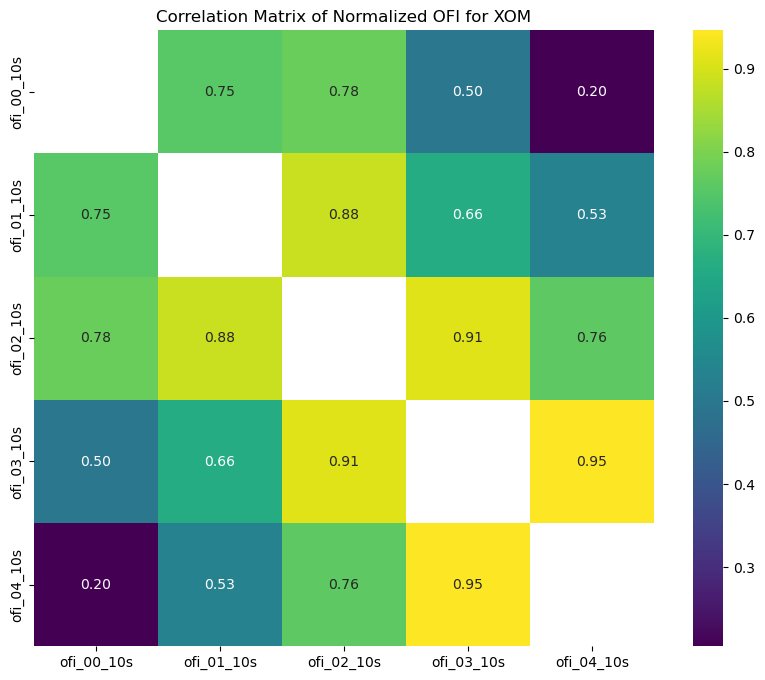

In [253]:
# Calculate correlation matrix
corr_cols = [f"ofi_{str(x).rjust(2, '0')}_{interval}" for x in range(5)]
corr_matrix = res[corr_cols].corr()

# Remove diagonal (where value is one)
np.fill_diagonal(corr_matrix.values, np.nan)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="viridis", cbar=True)
plt.title(f"Correlation Matrix of Normalized OFI for {symbol}")
plt.show()

In [254]:
corr_cols = [f"ofi_{str(x).rjust(2, '0')}_{interval}" for x in range(5)]
res[corr_cols].corr()

,ofi_00_10s,ofi_01_10s,ofi_02_10s,ofi_03_10s,ofi_04_10s
ofi_00_10s,1.000000,0.752264,0.777942,0.498691,0.204586
ofi_01_10s,0.752264,1.000000,0.882968,0.661827,0.530979
ofi_02_10s,0.777942,0.882968,1.000000,0.911069,0.763399
ofi_03_10s,0.498691,0.661827,0.911069,1.000000,0.946326
ofi_04_10s,0.204586,0.530979,0.763399,0.946326,1.000000


## Section 3 - Contemporaneous Cross-Impact

In [263]:
import statsmodels.formula.api as sm

Merge all stock csv

In [287]:
symbols = ["AAPL", "AMGB", "TSLA", "JPM", "XOM"]
df = pd.DataFrame()

for symbol in symbols:
    tmp = pd.read_csv(f"../data/processed/{symbol}_mbp-10.csv", index_col=0)
    tmp.index = pd.to_datetime(tmp.index)
    tmp.columns = [f"{symbol}_{c}" for c in tmp.columns]

    df = pd.concat([df, tmp], axis=1)

In [288]:
df.head()

,AAPL_symbol,AAPL_px_10s,AAPL_r_10s,AAPL_volume,AAPL_ofi_00_10s,AAPL_ofi_01_10s,AAPL_ofi_02_10s,AAPL_ofi_03_10s,AAPL_ofi_04_10s,AAPL_ofi_I_10s,...,XOM_symbol,XOM_px_10s,XOM_r_10s,XOM_volume,XOM_ofi_00_10s,XOM_ofi_01_10s,XOM_ofi_02_10s,XOM_ofi_03_10s,XOM_ofi_04_10s,XOM_ofi_I_10s
ts_recv,,,,,,,,,,,,,,,,,,,,,
2024-01-03 10:00:10+00:00,AAPL,184.705,NaN,0.0,0.000000,0.000000,0.000000,0.000000,-0.517241,-0.065403,...,XOM,184.705,NaN,0.0,0.000000,0.000000,0.000000,0.000000,-0.517241,-0.065403
2024-01-03 10:00:20+00:00,AAPL,184.710,0.000027,0.0,0.526316,3.157895,1.052632,0.526316,0.526316,0.598949,...,XOM,184.710,0.000027,0.0,0.526316,3.157895,1.052632,0.526316,0.526316,0.598949
2024-01-03 10:00:30+00:00,AAPL,184.680,-0.000162,92.0,-6.315789,-2.105263,-2.631579,-2.631579,-0.526316,0.003996,...,XOM,184.680,-0.000162,92.0,-6.315789,-2.105263,-2.631579,-2.631579,-0.526316,0.003996
2024-01-03 10:00:40+00:00,AAPL,184.650,-0.000162,8.0,-2.213115,-1.659836,-3.319672,-7.192623,-6.639344,1.360244,...,XOM,184.650,-0.000162,8.0,-2.213115,-1.659836,-3.319672,-7.192623,-6.639344,1.360244
2024-01-03 10:00:50+00:00,AAPL,184.650,0.000000,0.0,0.000000,0.000000,0.000000,0.483871,0.000000,-0.152453,...,XOM,184.650,0.000000,0.0,0.000000,0.000000,0.000000,0.483871,0.000000,-0.152453


In [280]:
interval = df.columns[1][-3:]

### Price Impact of best-level OFIs ( $ \textbf{PI}^{[1]} $ )

In [282]:
def regress(df, dependent_var, independent_vars):
    formula = f"{dependent_var} ~ {' + '.join(independent_vars)}"

    model = sm.ols(formula, data=df).fit()
    return model

In [289]:
symbol = 'AAPL'

independent_vars = [f'{symbol}_ofi_00_{interval}']  # Add more as needed
model = regress(df, f'{symbol}_r_{interval}', independent_vars)

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             AAPL_r_10s   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     4.890
Date:                Sun, 05 Jan 2025   Prob (F-statistic):              0.158
Time:                        00:02:06   Log-Likelihood:                 34.128
No. Observations:                   4   AIC:                            -64.26
Df Residuals:                       2   BIC:                            -65.48
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        -1.91e-05    4.2e-05     

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


### Price Impact of integrated OFIs ( $ \textbf{PI}^{I} $ )

In [295]:
symbol = "AAPL"

independent_vars = [f'{symbol}_ofi_I_{interval}']  # Add more as needed
model = regress(df, f'{symbol}_r_{interval}', independent_vars)

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             AAPL_r_10s   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                 -0.331
Method:                 Least Squares   F-statistic:                    0.2538
Date:                Sun, 05 Jan 2025   Prob (F-statistic):              0.664
Time:                        00:03:43   Log-Likelihood:                 31.893
No. Observations:                   4   AIC:                            -59.79
Df Residuals:                       2   BIC:                            -61.01
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -5.183e-05   7.41e-05     -0.

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


### Cross-Impact of best-level OFIs ( $ \textbf{CI}^{[1]} $ )

In [299]:
this_symbol = "AAPL"

independent_vars = [f'{symbol}_ofi_00_{interval}' for symbol in symbols]  # Add more as needed
model = regress(df, f'{this_symbol}_r_{interval}', independent_vars)

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             AAPL_r_10s   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     4.890
Date:                Sun, 05 Jan 2025   Prob (F-statistic):              0.158
Time:                        00:07:17   Log-Likelihood:                 34.128
No. Observations:                   4   AIC:                            -64.26
Df Residuals:                       2   BIC:                            -65.48
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        -1.91e-05    4.2e-05     

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


### Cross-Impact of Integrated OFIs ( $ \textbf{CI}^{I} $ )

In [297]:
[f"ofi_{str(x).rjust(2, '0')}_{interval}" for x in range(5)]

['ofi_00_10s', 'ofi_01_10s', 'ofi_02_10s', 'ofi_03_10s', 'ofi_04_10s']

In [300]:
this_symbol = "AAPL"

independent_vars = [f'{symbol}_ofi_I_{interval}' for symbol in symbols]  # Add more as needed
model = regress(df, f'{this_symbol}_r_{interval}', independent_vars)

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             AAPL_r_10s   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                 -0.331
Method:                 Least Squares   F-statistic:                    0.2538
Date:                Sun, 05 Jan 2025   Prob (F-statistic):              0.664
Time:                        00:07:28   Log-Likelihood:                 31.893
No. Observations:                   4   AIC:                            -59.79
Df Residuals:                       2   BIC:                            -61.01
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -5.183e-05   7.41e-05     -0.

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
